In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
from haversine import haversine, Unit
import folium
from geopy import distance
import matplotlib.pyplot as plt

In [87]:
# Load the csv file
zillow_df = pd.read_csv('Data/zillow2.csv')
parks_df = pd.read_csv('Data/nps-parks.csv')

# Drop rows with missing values for 'sqft' column
zillow_df.dropna(subset=['Square Feet'], inplace=True)

# print(zillow_df)


In [ ]:
#Data cleaning and getting rid of outliers

# print(zillow_df.dtypes)

# Outliers
zillow_df = zillow_df.drop(zillow_df[zillow_df['Address'].isin(['Canyon Plan, Juniper Trail', 'Stanton Plan, Juniper Trail', 'Cambria Plan, Juniper Trail'])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Price'].isin(['$536,500+','$535,500+', '$607,750+', '$588,750+', '$529,750+', ''])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Square Feet'].isin(['2,000 sqft','1,860 sqft', '4,000 sqft', '3,680 sqft', '2,971 sqft'])].index)
zillow_df  = zillow_df.drop(zillow_df[zillow_df['Latitude'].isin(['35.5641381'])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Longitude'].isin(['-121.0807468'])].index)


#Need to make Price and Square Feet into floats and numbers not strings. need to strip the $ and , from price and sqft and , from square feet.
zillow_df['Price'] = zillow_df['Price'].str.extract('(\d+)').astype(float)
# zillow_df['Price'] = zillow_df['Price'].replace('$','').astype(float)
zillow_df['Square Feet'] = zillow_df['Square Feet'].str.extract('(\d+)').astype(float)

# print(zillow_df.dtypes)





In [95]:
#These are parks outside of Utah. Need to drop them.
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Mormon Pioneer National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'California National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Pony Express National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Dinosaur National Monument'].index)

In [107]:
# Feature Engineering

zillow_df['price_per_sqft'] = zillow_df['Price'] / zillow_df['Square Feet']

# Save the cleaned dataframe to a new csv file
zillow_df.to_csv('houses_cleaned.csv', index=False)

zillow_df

,Unnamed: 0,Address,Price,Square Feet,Latitude,Longitude,price_per_sqft
0,0,"401 Silver King Dr #52, Park City, UT 84060",649.0,452.0,40.653621,-111.510835,1.435841
1,1,"3752 W Soft Whisper Way, Herriman, UT 84096",419.0,1.0,40.478933,-111.980032,419.000000
2,2,"445 N 100 W, Richfield, UT 84701",229.0,1.0,38.774316,-112.083100,229.000000
3,3,"754 E Logan Ave, Salt Lake City, UT 84105",650.0,1.0,40.734259,-111.869329,650.000000
4,4,"14506 S Ronan Ln UNIT 202, Herriman, UT 84096",355.0,1.0,40.487692,-111.993081,355.000000
...,...,...,...,...,...,...,...
166,166,"7457 E Stardust Ct #2.15, Heber City, UT 84032",410.0,3.0,40.598627,-111.293282,136.666667
167,167,"636 W Kokopelli Loop, Brian Head, UT 84719",674.0,2.0,37.707388,-112.859508,337.000000
168,168,"5225 N Dry Fork Canyon Rd, Vernal, UT 84078",1.0,4.0,40.530220,-109.623709,0.250000
169,169,"9450 S 1400 E, Sandy, UT 84092",550.0,1.0,40.579482,-111.851106,550.000000


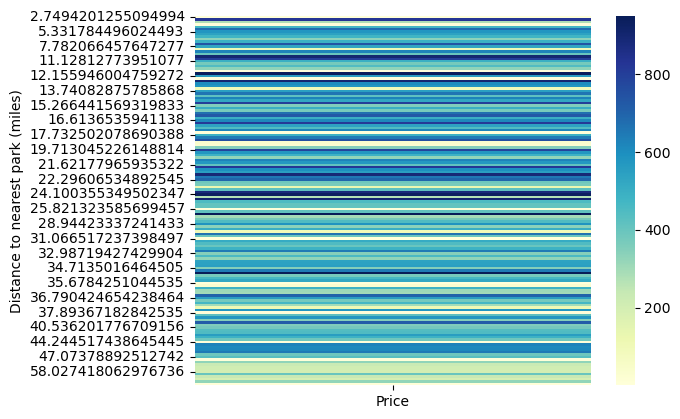

In [99]:
# Merge the two dataframes on latitude and longitude
merged_zillow_df = pd.merge(zillow_df, parks_df, on=['Latitude', 'Longitude'], how='left')

# Calculate the distance between each home and each park
distances = []
for index, row in merged_zillow_df.iterrows():
    home_loc = (row['Latitude'], row['Longitude'])
    park_locs = [(p['Latitude'], p['Longitude']) for _, p in parks_df.iterrows()]
    d = min([haversine(home_loc, p, unit=Unit.MILES) for p in park_locs])
    distances.append(d)
merged_zillow_df['Distance to nearest park (miles)'] = distances

# Group homes by distance to nearest park and calculate average price in each group
grouped_zillow_df = merged_zillow_df.groupby('Distance to nearest park (miles)').agg({'Price': 'mean'})

# Plot a heat map of average price as a function of distance to nearest park
sns.heatmap(grouped_zillow_df, cmap='YlGnBu')

# Plot a map of homes and parks
home_map = folium.Map(location=[39.5, -111.5], zoom_start=8)
for index, row in merged_zillow_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Price']).add_to(home_map)
for index, row in parks_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['name'], icon=folium.Icon(color='red')).add_to(home_map)
home_map

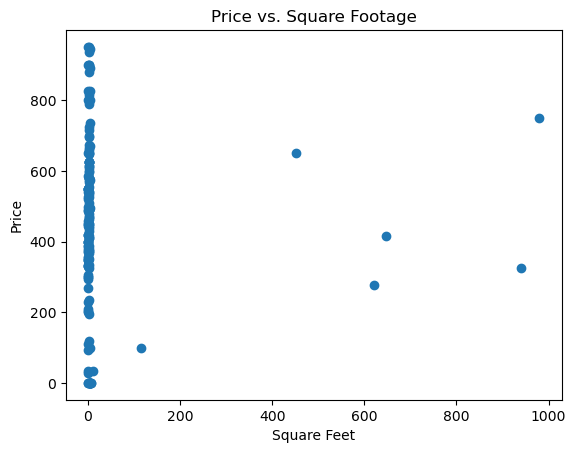

In [108]:
# Load the cleaned data
df = pd.read_csv('Data/houses_cleaned.csv')

# Plot square footage vs. price
plt.scatter(df['Square Feet'], df['Price'])
plt.title('Price vs. Square Footage')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.show()
